
# COVID-19 Prediction

## Data


In [2]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload

In [2]:
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

In [12]:
%autoreload
dataset = CountryDataset()

In [13]:
data = dataset.ox_augmented()

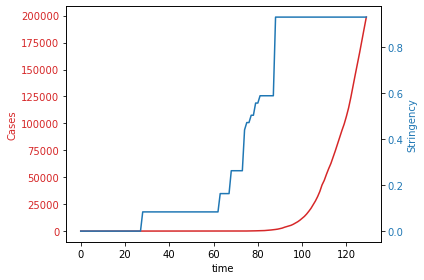

In [28]:
country_data = data[data['CountryName'] == 'Russia']

t = range(len(country_data))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Cases', color=color)
ax1.plot(t, country_data['ConfirmedCases'], label='cases', color=color)
# ax1.plot(t, values[:, 1], label='deaths', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Stringency', color=color)
ax2.plot(t, country_data['StringencyIndexForDisplay'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In [29]:
train_data, test_data, _ = dataset.ox_train_test(rescaling=(rescaling:=1000))

In [30]:
m2, m1 = make_targets_df(train_data)
different = m1['ConfirmedCases'].reset_index(drop=True) != m2['ConfirmedCases'].reset_index(drop=True)
m2, m1 = m2.loc[different], m1.loc[different]
print('Train samples: ', len(m1.index))

test_m2, test_m1 = make_targets_df(test_data)
different = test_m1['ConfirmedCases'].reset_index(drop=True) != test_m2['ConfirmedCases'].reset_index(drop=True)
test_m2, test_m1 = test_m2.loc[different], test_m1.loc[different]
print('Test samples: ', len(test_m1.index))

Train samples:  5881
Test samples:  1227


In [14]:
def make_polynomials_df(data, variables, predicted_variables, time_dependent_variables=None, max_degree=2):
    """Returns the augmented array and the number of transformations"""
    variables = ['1'] + list(variables)
    
    def sparse_list(count):
        return [1]*count + [np.nan]*(max_degree - count)
    
    if '1' not in data.columns:
        data['1'] = 1
    result = pd.DataFrame()
    integration_args = {"constant_variables": [], "sparse_filters": []}
    if not time_dependent_variables:
        time_dependent_variables = predicted_variables
    for columns in combinations_with_replacement(variables, max_degree):
        if not set(predicted_variables).isdisjoint(columns):
            result['*'.join(columns)] = data.loc[:, columns].prod(axis=1, numeric_only=True)
            integration_args['constant_variables'].append([col for col in columns if col not in time_dependent_variables + ['1']])
            integration_args['sparse_filters'].append(sum([sparse_list(columns.count(col)) for col in time_dependent_variables], []))
    integration_args['sparse_filters'] = np.array(integration_args['sparse_filters'])
    return result, integration_args

poly_args = {
    'variables': ['ConfirmedCases', 'ShiftedStringency', 'SH.MED.BEDS.ZS', 'SH.MED.PHYS.ZS', 'SH.MED.NUMW.P3', 'SH.UHC.SRVS.CV.XD', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.CHEX.PC.CD', 'SH.XPD.CHEX.PP.CD', 'SH.XPD.OOPC.CH.ZS', 'SH.XPD.OOPC.PC.CD', 'SH.XPD.OOPC.PP.CD', 'SH.STA.DIAB.ZS', 'SP.DYN.LE00.FE.IN', 'SP.DYN.LE00.IN', 'SP.DYN.LE00.MA.IN', 'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA', 'SH.DYN.NCOM.ZS', 'SH.DYN.NCOM.FE.ZS', 'SH.DYN.NCOM.MA.ZS', 'SH.DTH.COMM.ZS', 'SH.DTH.INJR.ZS', 'SH.DTH.NCOM.ZS', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS', 'SP.POP.80UP.FE.5Y', 'SP.POP.80UP.MA.5Y', 'SP.POP.65UP.FE.ZS', 'SP.POP.65UP.MA.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.FE.ZS', 'SP.POP.0014.MA.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.FE.ZS', 'SP.POP.1564.MA.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL', 'HDI'],
    'time_dependent_variables': ['ConfirmedCases', 'ShiftedStringency'],
    'predicted_variables': ['ConfirmedCases'],
    'max_degree': 3
}

X, integration_args = make_polynomials_df(m1, **poly_args)
X_test, integration_args = make_polynomials_df(test_m1, **poly_args)

## Global model

 85%|███████████  | 34/40 [08:13<00:30,  5.10s/it]<ipython-input-16-2afae50cae5a>:2: RuntimeWarning: invalid value encountered in true_divide
  return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
100%|█████████████| 40/40 [08:34<00:00, 12.87s/it]


[]

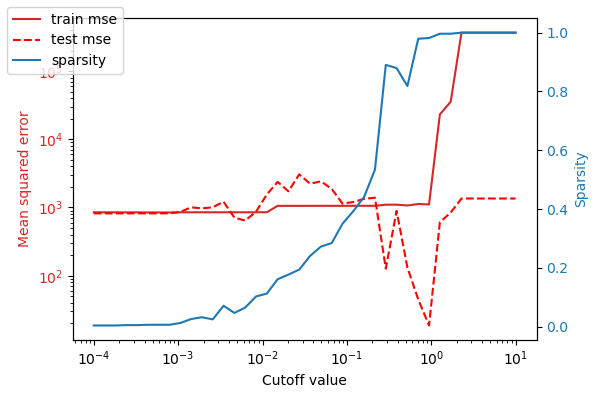

In [16]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


cutoffs = np.logspace(-4, 1, num=40)
sparsity = []
mses = []
test_mses = []
smapes = []
all_weights = []
best_weights = {'smape': (None, 1e25, 0),
                'test_mse': (None, 1e25, 0),
                'train_mse': (None, 1e25, 0)}
for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=k)
    mse = ((tf.matmul(tf.cast(X.values, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[poly_args['predicted_variables']].values)**2).numpy().mean()
    mses.append(mse)
    test_predictions = tf.matmul(tf.cast(X_test.values, dtype=tf.float32), tf.cast(weights, dtype=tf.float32))
    test_mse = ((test_predictions - test_m2[poly_args['predicted_variables']].values)**2).numpy().mean()
    test_mses.append(test_mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))
    current_smape = smape(test_predictions, test_m2[poly_args['predicted_variables']].values)
    smapes.append(current_smape)
    all_weights.append(weights)
    if test_mse <= best_weights['test_mse'][1]:
        best_weights['test_mse'] = weights, test_mse, k
    if mse <= best_weights['train_mse'][1]:
        best_weights['train_mse'] = weights, mse, k
    if current_smape <= best_weights['smape'][1]:
        best_weights['smape'] = weights, current_smape, k

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='train mse')
ax1.plot(cutoffs, test_mses, 'r--', label='test mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)  # we already handled the x-label with ax1
# ax2.plot(cutoffs, smapes, color='tab:purple', label='test smape')
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.plot()
# plt.savefig('sparsity_vs_mse.png', dpi=100)


In [41]:
# weights, _ = sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=2e-3)
# integration_args['weights'] = weights

integration_args['weights'] = best_weights['test_mse'][0]

weights = integration_args['weights']


mse = ((tf.matmul(tf.cast(X.values, dtype=tf.float32), weights) - m2[poly_args['predicted_variables']].values)**2).numpy().mean()

mse, (weights.numpy() != 0).sum(), weights

# show_weights(weights, derivative=False)

(1108.1407,
 15,
 <tf.Tensor: shape=(820, 1), dtype=float32, numpy=
 array([[  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0.       ],
        [  0

In [43]:
1 - 15/820

0.9817073170731707

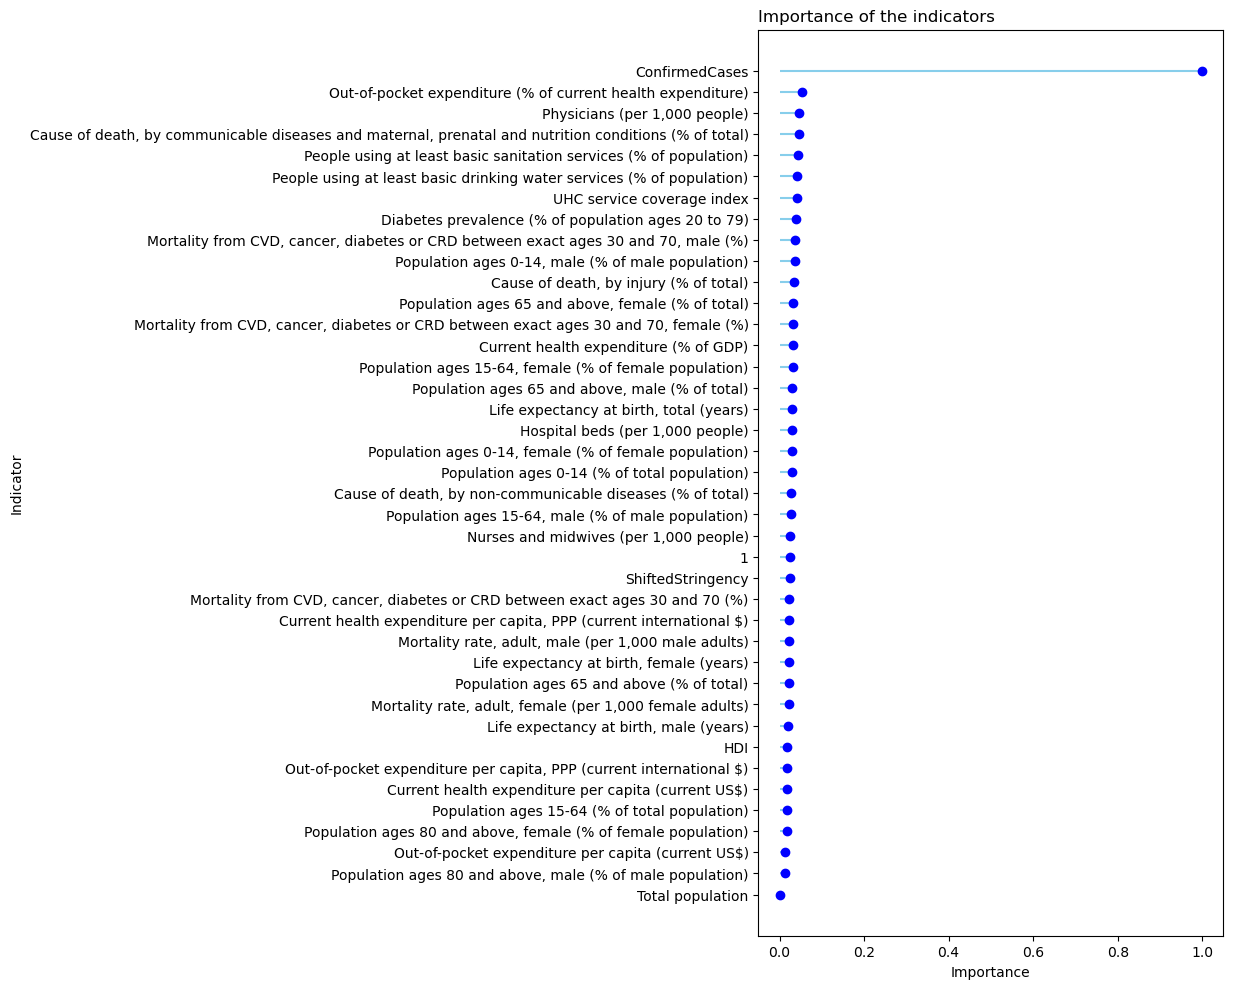

In [40]:
coefficients = [a.split('*') for a in X.columns]
masses = []
indics = [] 

plot_weights = weights

for indicator in m1.columns:
    weight = 0
    for coefs, w in zip(coefficients, plot_weights):
        if indicator in coefs:
            weight += abs(w.numpy()[0])
    if weight != 0:
        masses.append(weight)
        if indicator in indicators_description.keys():
            indics.append(indicators_description[indicator])
        else:
            indics.append(indicator)
        
masses = np.array(masses)
    
plt.figure(figsize=(6, len(masses)*0.3), dpi=100)
# Create a dataframe
df = pd.DataFrame({'group':indics, 'values':masses})
df['values'] = (df['values']-df['values'].min())/(df['values'].max()-df['values'].min()) # normalization


ordered_df = df.sort_values(by='values')
ordered_df
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color='skyblue')
plt.plot(ordered_df['values'], my_range, "o", color='blue')
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['group'])
plt.title("Importance of the indicators", loc='left')
plt.xlabel('Importance')
plt.ylabel('Indicator')
plt.savefig('reports/importances_train.png', dpi=100, bbox_inches = 'tight')
plt.show()

In [ ]:
coefficients = [a.split('*') for a in X.columns]
importances = []
indics = [] 

for _weights in tqdm(all_weights):
    current_importances = []
    for indicator in m1.columns:
        weight = 0
        for coefs, w in zip(coefficients, _weights):
            if indicator in coefs:
                weight += abs(w.numpy()[0])
        current_importances.append(weight)
    importances.append(np.array(current_importances)/max(current_importances))
importances = np.array(importances)
plt.figure(figsize=(8, 10))
plt.plot(cutoffs, importances)
plt.xlabel('Cutoff value')
plt.ylabel('Importances')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
list(X.columns)

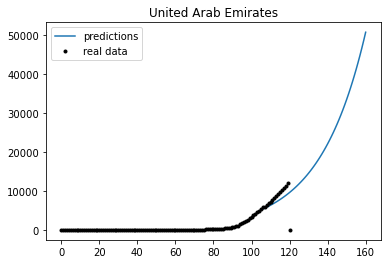

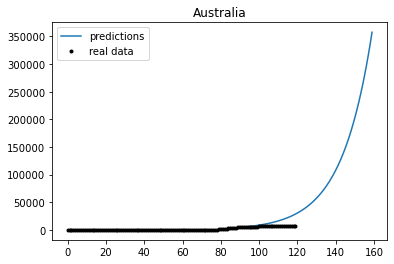

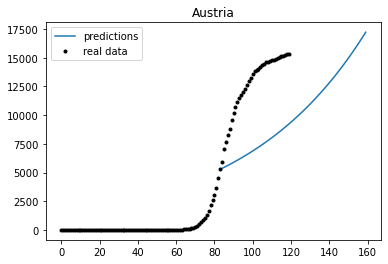

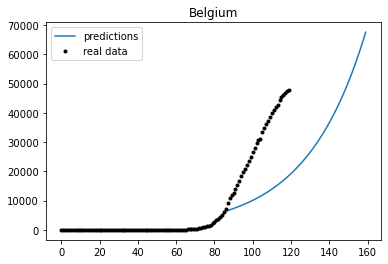

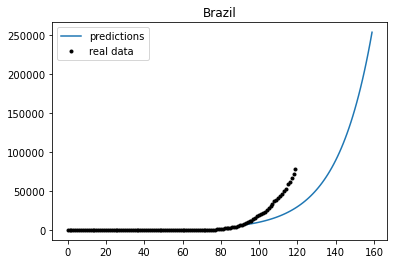

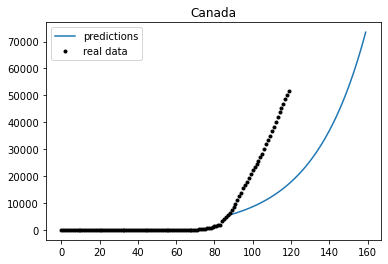

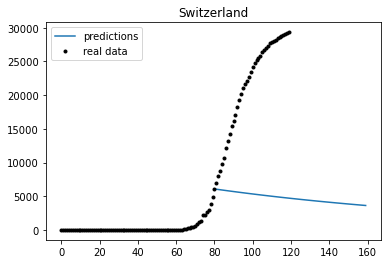

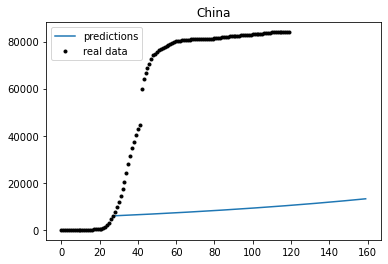

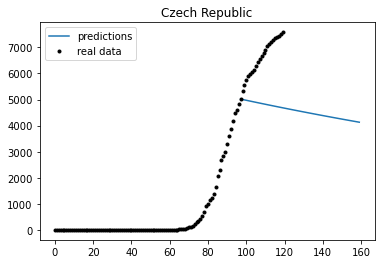

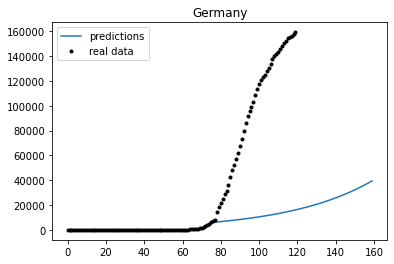

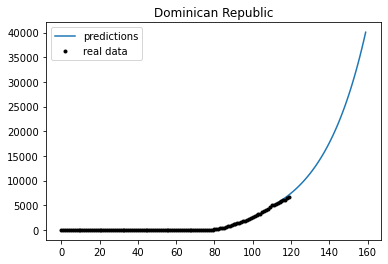

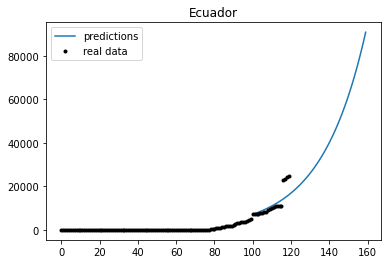

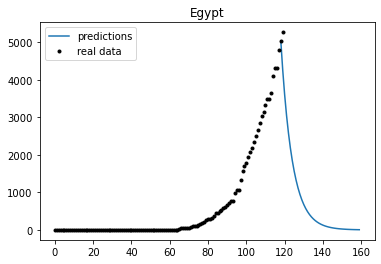

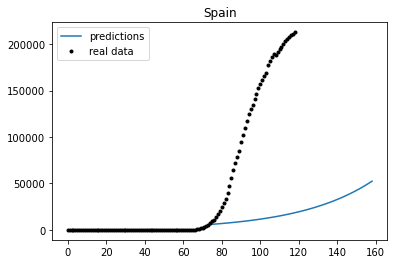

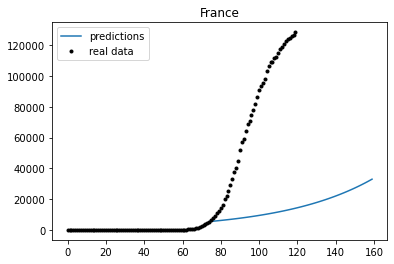

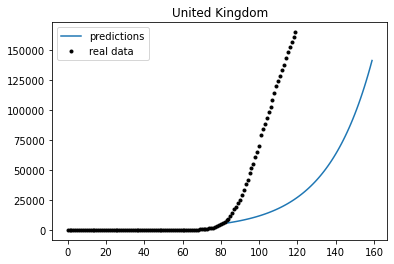

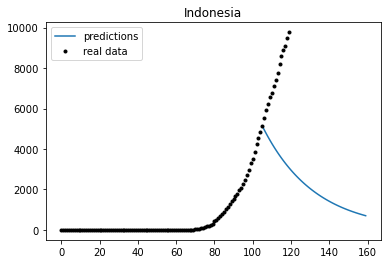

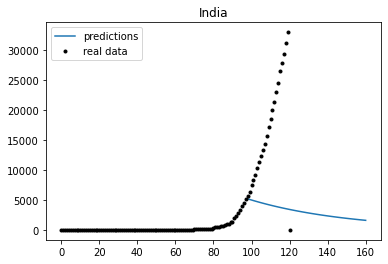

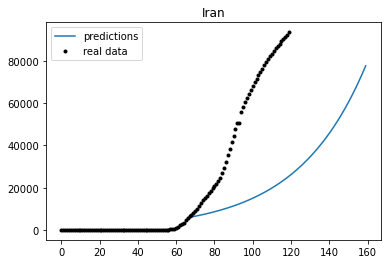

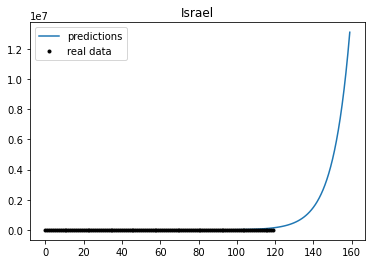

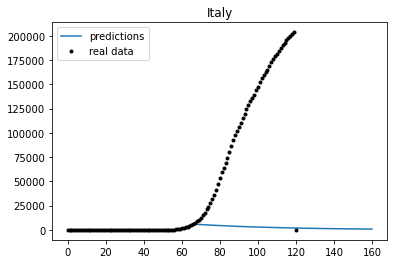

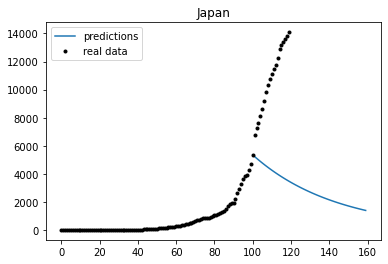

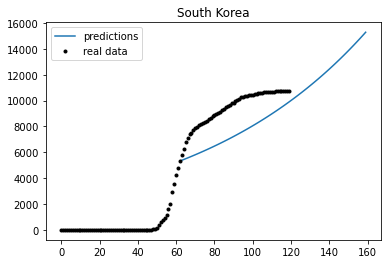

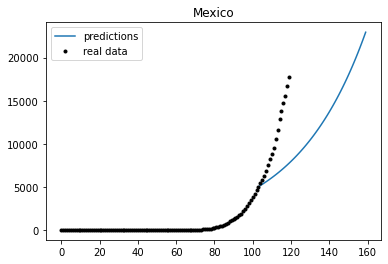

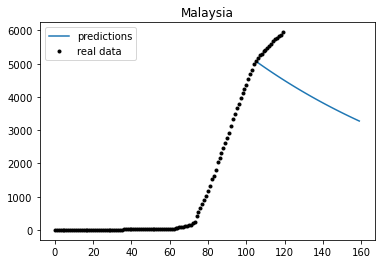

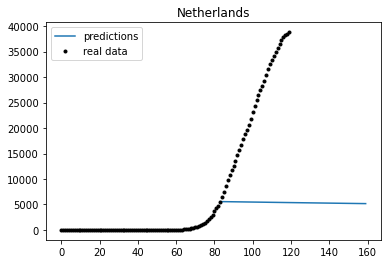

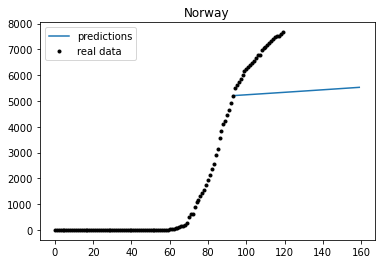

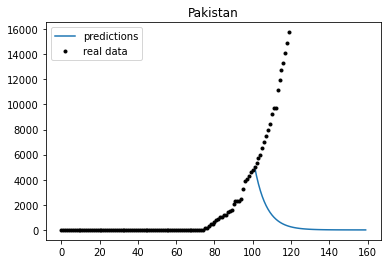

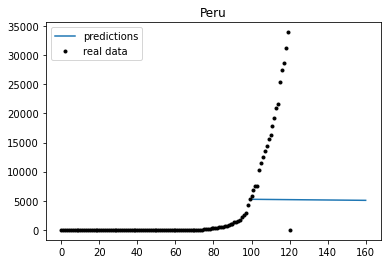

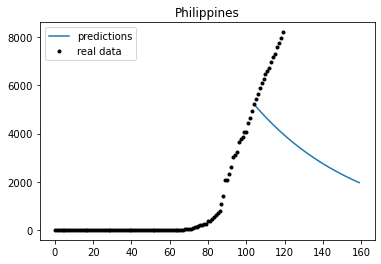

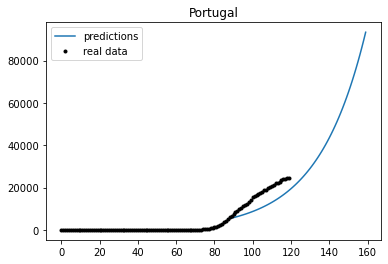

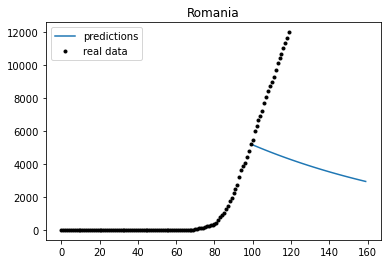

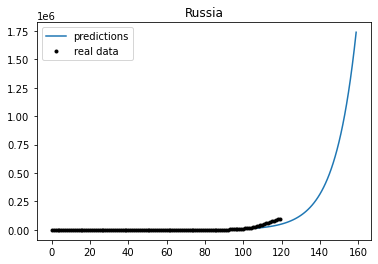

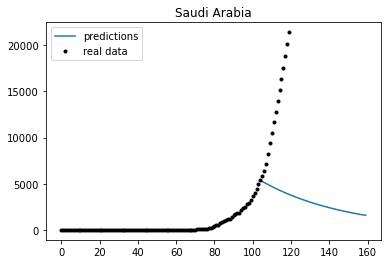

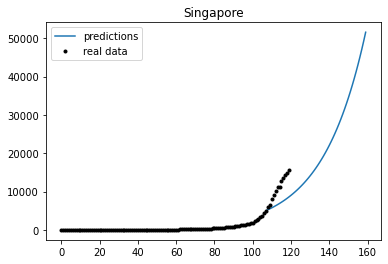

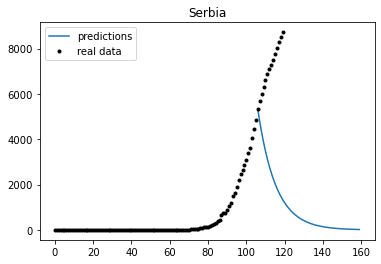

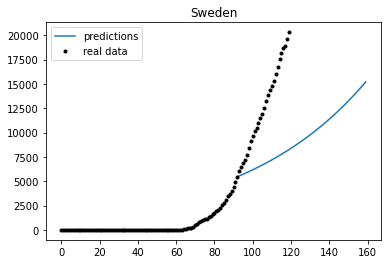

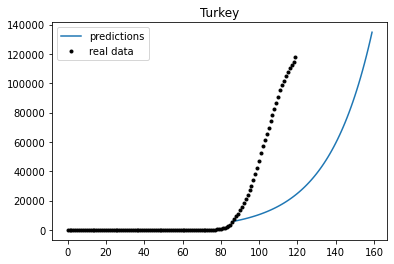

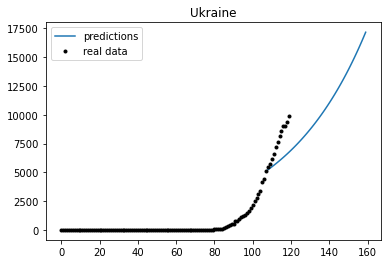

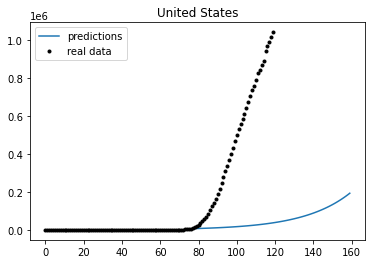

In [45]:
plotted_countries = []

for country in train_countries:
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        plt.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        plt.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        plt.legend()
        plt.title(country)
        
#         fig, ax1 = plt.subplots()
#         color = 'tab:blue'
#         ax1.set_xlabel('time')
#         ax1.set_ylabel('Cases', color=color)
#         ax1.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
#         ax1.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
#         ax1.tick_params(axis='y', labelcolor=color)

#         ax2 = ax1.twinx()

#         color = 'tab:red'
#         ax2.set_ylabel('Stringency', color=color)
#         ax2.plot(t[:-extrapolation], country_data['ShiftedStringency'], color=color, alpha=0.7)
#         ax2.tick_params(axis='y', labelcolor=color)
#         plt.title(country)
        fig.tight_layout()
        plt.savefig(f'test_plots/{country}.png', dpi=100)
        plotted_countries.append(country)
        plt.show()

In [ ]:
best_weights['test_mse'][0].numpy()

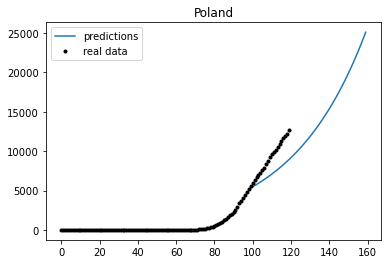

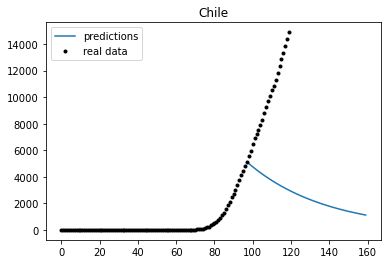

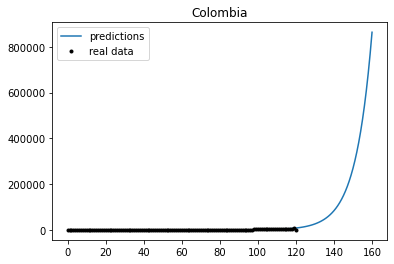

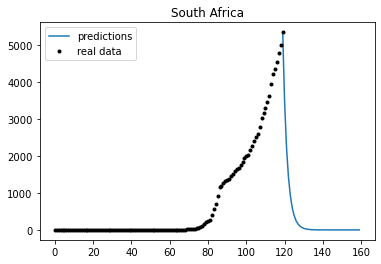

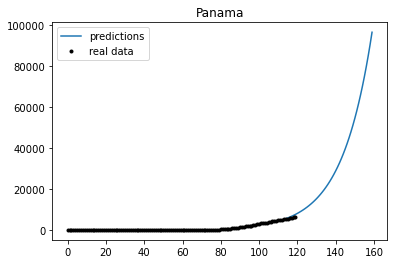

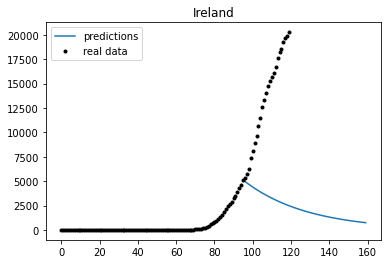

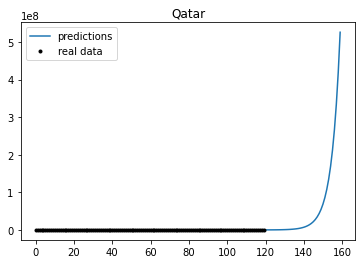

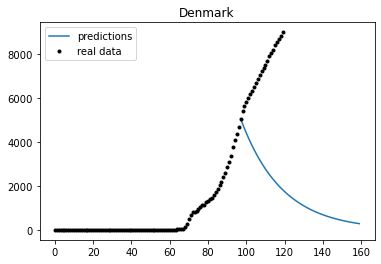

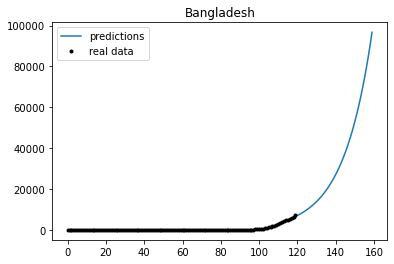

In [46]:
plotted_countries = []
for country in test_countries:
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        plt.plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        plt.plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        plt.legend()
        plt.title(country)
        plt.savefig(f'test_plots/{country}.png', dpi=100)
        plt.show()
        plotted_countries.append(country)

In [ ]:
from itertools import product
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for (a, b), country in zip(product([0, 1, 2], [0, 1]), ['Belgium', 'Brazil', 'China', 'France', 'India', 'Turkey']):
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        axs[a, b].plot(t[-real_t-extrapolation:], guess[:, 0]*rescaling, label='predictions')
        axs[a, b].plot(t[:-extrapolation], country_data['ConfirmedCases']*rescaling, 'k.', label='real data')
        axs[a, b].legend()
        axs[a, b].set_title(country)
        if a == 2:
            axs[a, b].set(xlabel='time')
        if b == 0:
            axs[a, b].set(ylabel='cases')

plt.show()

In [ ]:
fig.savefig('reports/successful.png')

In [ ]:
from itertools import product
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for (a, b), country in zip(product([0, 1], [0, 1]), ['Australia', 'Japan', 'Chile', 'Denmark']):
    country_data = data[data['CountryName'] == country]
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
    real_t = len(high_data.index)
    if real_t:
        guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
        axs[a, b].plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
        axs[a, b].plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
        axs[a, b].legend()
        axs[a, b].set_title(country)
        if a == 1:
            axs[a, b].set(xlabel='time')
        if b == 0:
            axs[a, b].set(ylabel='cases')


plt.show()